# Behavioral figures


In [154]:
# Load data
import glob
import os.path as op
import numpy as np
import pandas as pd
import json
import os
from datetime import datetime

training_folder = '/home/hyruuk/GitHub/neuromod/shinobi_training'
scan_folder = '/home/hyruuk/GitHub/neuromod/shinobi'

# Obtain filelist
training_files = glob.glob(op.join(training_folder, 'sub*/ses*/*/*.bk2'))
scan_files = glob.glob(op.join(scan_folder, 'sub*/ses*/*/*.bk2'))

allfiles = sorted(training_files + scan_files)

def load_json(jsonfile):
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    return data

def init_datadict():
    datadict = {
        'Subject':[], 
        'Level':[], 
        'Setup':[],
        'Health loss':[], 
        'Final score':[], 
        'Proportion cleared':[],
        'Days of training':[],
        'Index':[],
        'Cleared/Failed ratio':[],
        'Timestamp':[]
    }
    return datadict

def add_to_dict(datadict, replayfile, index=0):
    data = load_json(replayfile.replace('.bk2', '.json'))
    setup = 'Scan' if 'run-' in replayfile else 'Train'
    if data['FakeRep'] == False:
        datadict['Subject'].append(data['SubjectID'])
        datadict['Level'].append(data['Level'])
        datadict['Setup'].append(setup)
        datadict['Health loss'].append(-int(data['TotalHealthLost']))
        datadict['Final score'].append(int(data['FinalScore']))
        datadict['Proportion cleared'].append(float(data['PercentComplete']) if float(data['PercentComplete']) < 100 else 100)
        datadict['Days of training'].append(float(data['DaysOfTraining']) if setup == 'Train' else np.nan)
        datadict['Index'].append(index)
        datadict['Cleared/Failed ratio'].append(int(data['Cleared']))
        datadict['Timestamp'].append(int(data['LevelStartTimestamp']) if setup == 'Train' else np.nan)
    else:
        print(f'Fake replay discarded : {replayfile}')
    return datadict, index+1


datadict = init_datadict()
for subject in ['sub-01', 'sub-02', 'sub-04', 'sub-06']:
    for level in ['level-1', 'level-4', 'level-5']:
        for setup in ['Train', 'Scan']:
            filtered_files = [x for x in allfiles if subject in x and level in x]
            if setup == 'Scan':
                filtered_files = [x for x in filtered_files if 'run-' in x]
            else:
                filtered_files = [x for x in filtered_files if 'run-' not in x]
            index = 0
            for replayfile in filtered_files:
                try:
                    datadict, index = add_to_dict(datadict, replayfile, index)
                except Exception as e:
                    print(e)
                    print('Error from file : ', replayfile)

# Create a dataframe
df = pd.DataFrame(datadict)

# Split the training
df['Setup split(days)'] = df['Setup']
df['Setup split(idx)'] = df['Setup']
for subject in np.unique(df.Subject):
    for level in np.unique(df.Level):
        minidf = df[(df['Setup']=='Train') & (df['Subject']==subject) & (df['Level']==level)]
        # Create both splitting based on index and timestamp
        maxindex = np.max(minidf.Index) # Deprec
        training_start = datetime.fromtimestamp(np.min(minidf.Timestamp)) # Now we use timestamps instead of index
        for row in minidf.iterrows():
            current_date = datetime.fromtimestamp(row[1].Timestamp)
            if (current_date - training_start).days < 14:
                df.loc[row[0], 'Setup split(days)'] = 'Train (0-1w)'
            elif 14 <= (current_date - training_start).days < 84:
                df.loc[row[0], 'Setup split(days)'] = 'Train (1-12w)'
            else:
                df.loc[row[0], 'Setup split(days)'] = 'Train (12w+)'
            if row[1].Index < maxindex/2:
                df.loc[row[0], 'Setup split(idx)'] = 'Train (0-50%)'
            else:
                df.loc[row[0], 'Setup split(idx)'] = 'Train (50-100%)'
            


Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_training/sub-01/ses-001/beh/sub-01_ses-001_task-shinobi_level-1_rep-001_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-013_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-014_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-036_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-038_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1_rep-039_gamedata.bk2
Fake replay discarded : /home/hyruuk/GitHub/neuromod/shinobi_training/sub-01/ses-005/beh/sub-01_ses-005_task-shinobi_level-1

In [152]:
for subj in np.unique(df.Subject):
    for level in np.unique(df.Level):
        filtered_df = df[(df.Subject == subj) & (df.Level == level)]
        print(f'{subj} {level}')
        print(np.unique(filtered_df.Setup, return_counts=True))

row[1].Index

sub-01 level-1
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([87, 73, 85, 29]))
sub-01 level-4
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([61, 63, 12, 35]))
sub-01 level-5
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([53, 58,  9, 49]))
sub-02 level-1
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([ 77,  13,   2, 246]))
sub-02 level-4
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([ 57,   4, 264,  22]))
sub-02 level-5
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([55, 31, 15,  5]))
sub-04 level-1
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), array([67,  9,  5, 43]))
sub-04 level-4
(array(['Scan', 'Train (0-1w)', 'Train (1-12w)', 'Train (12w+)'],
      dtype=object), a

36

## Learning curves

In [143]:
os.makedirs('../data/processed', exist_ok=True)
df.to_csv('../data/processed/D1_behavioral_df.csv', index=False)

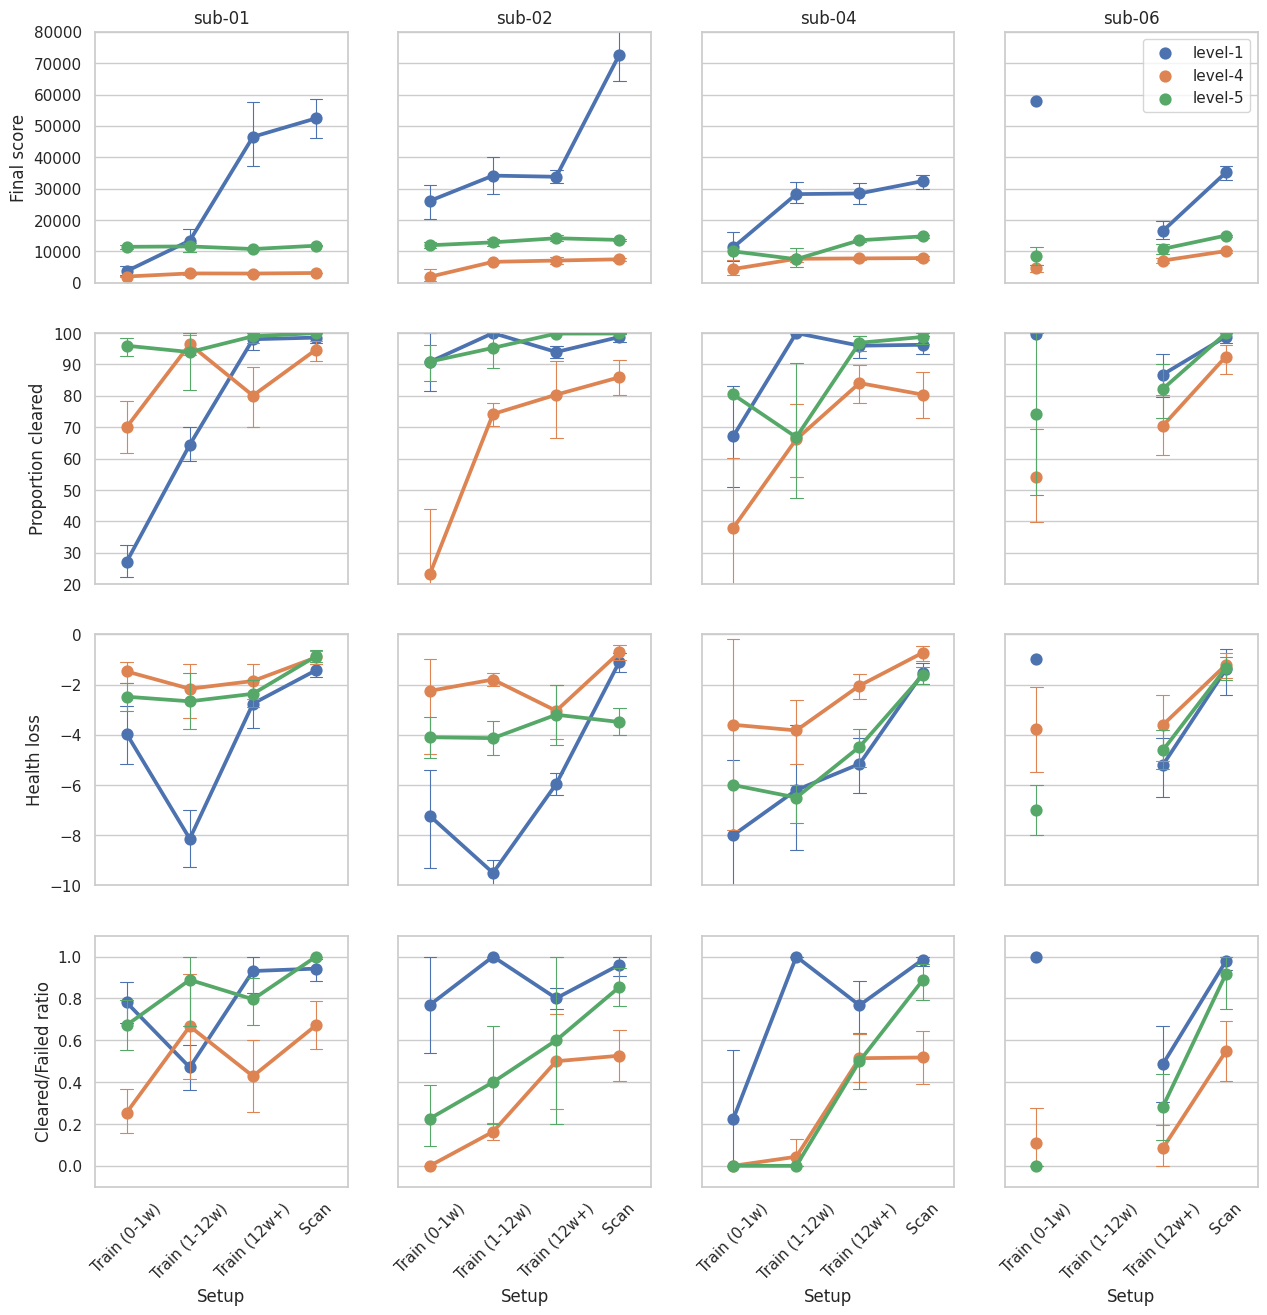

In [157]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_theme(style="whitegrid")


# Load the example exercise dataset
#df = sns.load_dataset("exercise")
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(4,4)

for idx_var, var in enumerate(['Final score', 'Proportion cleared', 'Health loss', 'Cleared/Failed ratio']):
    for idx_sub, sub in enumerate(np.unique(df['Subject'])):
        ax = plt.subplot(gs[idx_var, idx_sub])
        vmin = [0,20,-10,-0.1]
        vmax = [80000,100,0,1.1]
        #sns.stripplot(x="Setup", y=var, hue="Level",
        #              size=3, alpha=0.2,
        #              data=df[df['Subject']==sub], ax=ax)
        
        sns.pointplot(x="Setup split(days)", y=var, hue="Level",
                      capsize=.2, height=6, aspect=.75, 
                      errwidth=0.8, order=['Train (0-1w)', 'Train (1-12w)', 'Train (12w+)', 'Scan'],
                      data=df[df['Subject']==sub], ax=ax)
        
        # Polish
        ax.set_ylim([vmin[idx_var], vmax[idx_var]])
        plt.legend().remove()
        ax.set_xlabel('Setup') # Force Setup xlabel name
        if idx_var == 0 and idx_sub == 3:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[:3], labels=labels[:3])
        if idx_var == 0:
            plt.title(sub)
        if not idx_var == 3:
            ax.set_xticklabels([])
            ax.set_xlabel('')
        if not idx_sub == 0:
            ax.set_yticklabels([])
            ax.set_ylabel('')
        plt.xticks(rotation=45)

## Train vs Scan

In [100]:
# Select only the training data
lcurves_df = df[df['Setup'] != 'Scan']

# Apply a rolling median to smooth the curves
numerical_cols = ['Days of training', 'Final score', 'Proportion cleared', 'Health loss', 'Cleared/Failed ratio']
rolling_df = df[numerical_cols].rolling(window=5).mean()
lcurves_df[numerical_cols] = rolling_df

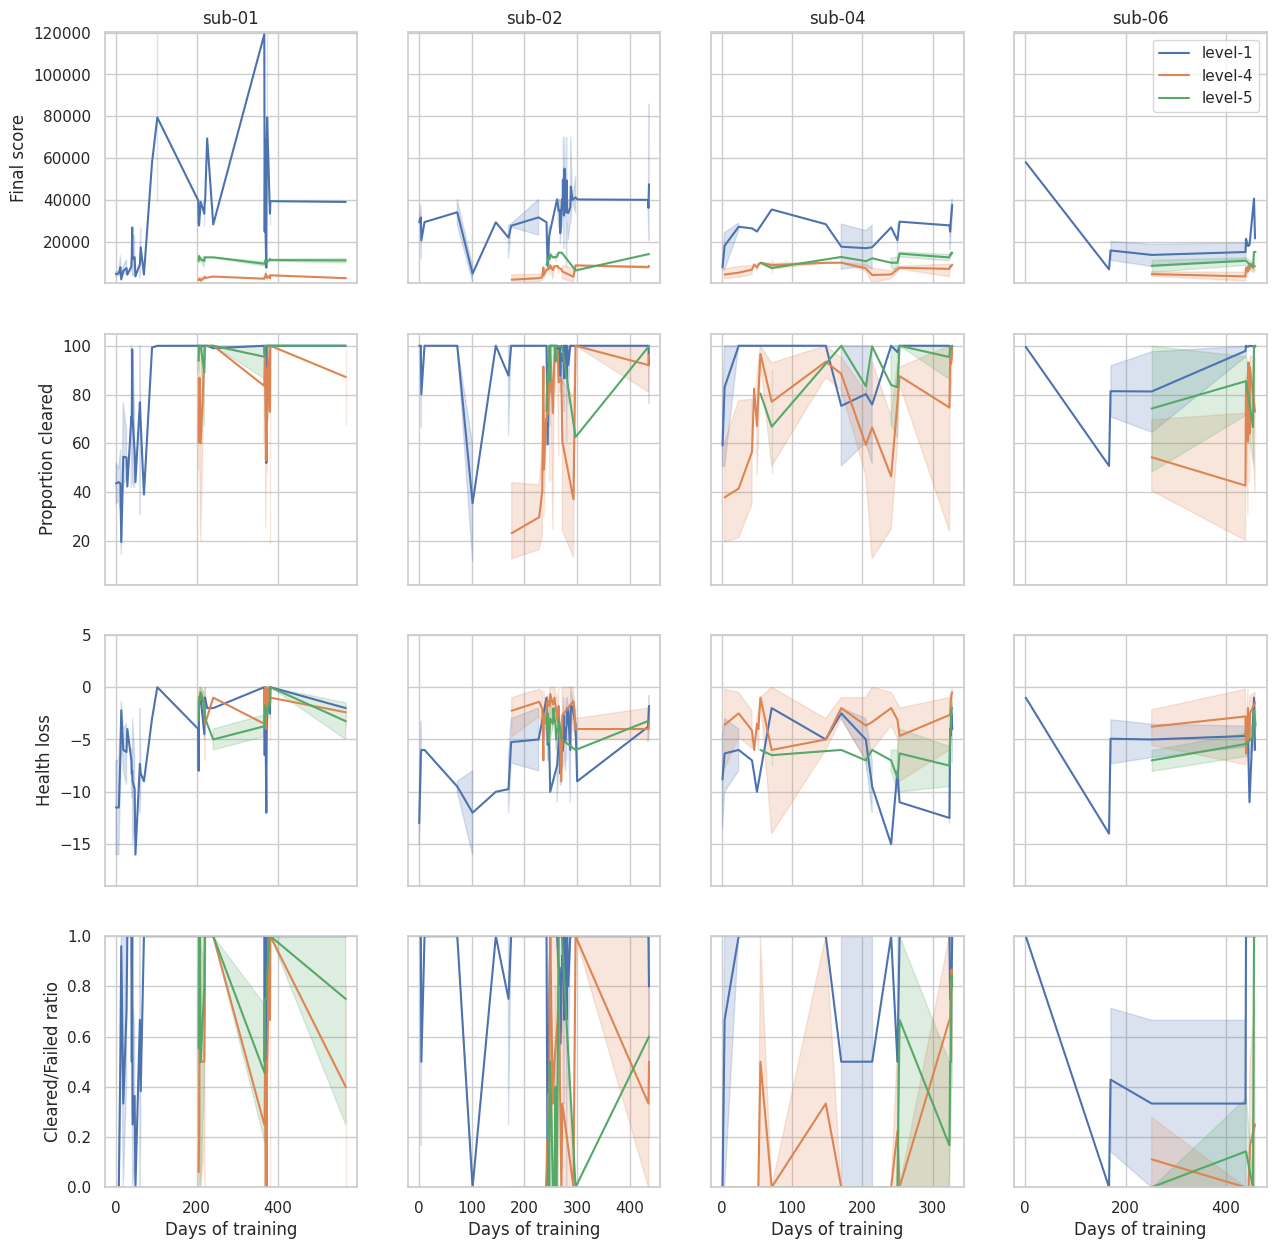

In [101]:
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(4,4)

for idx_var, var in enumerate(['Final score', 'Proportion cleared', 'Health loss', 'Cleared/Failed ratio']):
    for idx_sub, sub in enumerate(np.unique(lcurves_df['Subject'])):
        ax = plt.subplot(gs[idx_var, idx_sub])
        vmin = np.min(lcurves_df[var])
        vmax = np.max(lcurves_df[var])+5
        if var == 'Cleared/Failed ratio':
            vmax += -5
        
        sns.lineplot(x="Days of training", y=var, hue="Level",
                      data=lcurves_df[lcurves_df['Subject']==sub], ax=ax)
        
        # Polish
        ax.set_ylim([vmin, vmax])
        
        plt.legend().remove()
        if idx_var == 0 and idx_sub == 3:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[:3], labels=labels[:3])

        if idx_var == 0:
            plt.title(sub)
        if not idx_var == 3:
            ax.set_xticklabels([])
            ax.set_xlabel('')
        if not idx_sub == 0:
            ax.set_yticklabels([])
            ax.set_ylabel('')

,Final score,Proportion cleared,Health loss,Cleared/Failed ratio
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,5410.0,47.589744,-16.0,0.0
...,...,...,...,...
2000,15220.0,100.000000,-2.0,1.0
2001,15230.0,100.000000,-2.0,1.0
2002,15230.0,100.000000,-2.0,1.0
2003,15230.0,100.000000,-4.0,1.0
